## 1. Introduction: What is pneumonia?

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.
Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.
(For more info please visit: https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204)

## 1.1 Goal 


The goal of this project is to demonstrate how machine learning can enhance healthcare operations by automating certain tasks. Through deep learning models, we can provide clinicians with data-driven insights to allow for better decision making by saving time and money diagnosing illnesses. In this scenario, we will be looking into chest X-ray images (anterior-posterior) from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. By leveraging neural network models, we can classify chest X-rays as either showing signs of pneumonia or appearing normal to reduce diagnostic errors and expedite treatment. We will fine tune hyperparameters to optimize performance and prevent overfitting. This task will be repeated until the classification accuracy reaches satisfactory (>90%). As a result, we hope that utilizing machine learning frameworks such as TensorFlow will allow for more accessable healthcare for those in underserved areas by reducing the time and cost for treatment.  

## 2. Importing The Neccesary Libraries

In [ ]:
 # TensorFlow and keras
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# Scikitlearn, PCA and TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# numpy, pandas, seaborn and random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# os and cv
import cv2
import os

import warnings

## 3. Settings For Reproducibility

In [2]:
# Set the seed for hash-based operations in Python
os.environ['PYTHONHASHSEED'] = '0'

# Set the random seed for Python's random module
random.seed(0)

# Set the random seed for numpy
np.random.seed(0)

# Set the random seed for TensorFlow (use tf.random.set_seed() in TF2.x)
tf.random.set_seed(0)


# Set TensorFlow deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Disable multi-threading in tensorflow ops for reproducibility
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)


config = ConfigProto()
config.gpu_options.allow_growth = True  
session = Session(config = config)

# Disable all warnings
warnings.filterwarnings("ignore")


## 4. Import and Load The Data Set

Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [4]:
# X-ray results
labels = ['PNEUMONIA', 'NORMAL']

# Dimension of images
img_size = 150

# Get data to assign to respective training/testing/validation datasets
def get_data(data_dir):
    images = []
    labels_list = []
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                images.append(resized_arr)
                labels_list.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    # Convert to numpy arrays
    images = np.array(images)
    labels_list = np.array(labels_list)

    return images, labels_list

In [5]:
# Paths for each directory
train_dir = os.path.join(path, "chest_xray/train")
test_dir = os.path.join(path, "chest_xray/test")
val_dir = os.path.join(path, "chest_xray/val")

In [6]:
# Load datasets
train_images, train_labels = get_data(train_dir)
test_images, test_labels = get_data(test_dir)
val_images, val_labels = get_data(val_dir)


## 5. Exploratory Data Analysis / Pre-processing 

In [7]:
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)

Training images shape: (5216, 150, 150)
Training labels shape: (5216,)


In [8]:
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Test images shape: (624, 150, 150)
Test labels shape: (624,)


In [9]:
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)

Validation images shape: (16, 150, 150)
Validation labels shape: (16,)


In [10]:
print('Type:', type(train_images[0]))
print('Train image value range:', (np.min(train_images), np.max(train_images)))

Type: <class 'numpy.ndarray'>
Train image value range: (np.uint8(0), np.uint8(255))


In [11]:
print('Test image value range:', (np.min(test_images), np.max(test_images)))
print('Set of label values', set(test_labels))

Test image value range: (np.uint8(0), np.uint8(255))
Set of label values {np.int64(0), np.int64(1)}


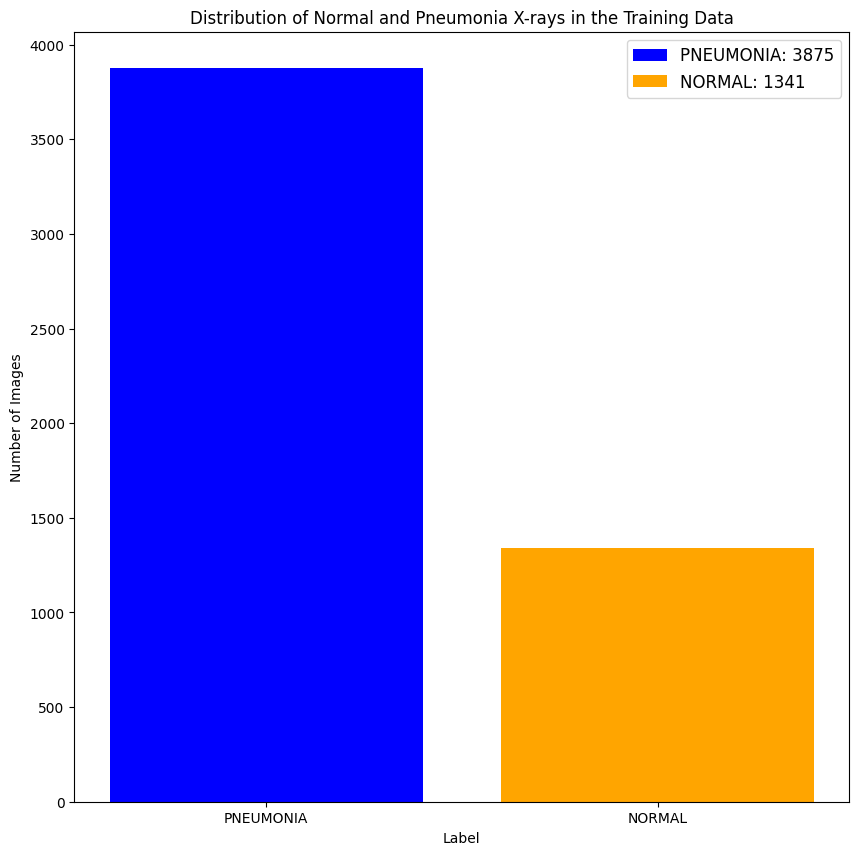

In [12]:
# Count the number of each label
unique, counts = np.unique(train_labels, return_counts = True)
label_counts = dict(zip(labels, counts))

# Plot
plt.figure(figsize = (10, 10))
bars = plt.bar(label_counts.keys(), label_counts.values(), color = ['blue', 'orange'])

legend_label = [f"{label}: {count}" for label, count in label_counts.items()]

plt.legend(bars, legend_label, loc = 'upper right', fontsize = 12)

plt.title("Distribution of Normal and Pneumonia X-rays in the Training Data")

plt.ylabel("Number of Images")
plt.xlabel("Label")

plt.show()


From the graph we can observe that the number of pneumonia images is far greater than the normal X-ray images. In order to provide the most accurate model possible we can go two ways, adjusting the class weights or rotating the images for better feature collection. We will proceed with the latter. 

In [13]:
# Scale to a range of 0 to 1
train_images = train_images / 255
test_images = test_images / 255
val_images = val_images / 255

# Reshape
train_images = train_images.reshape(-1, img_size, img_size, 1)
test_images = test_images.reshape(-1, img_size, img_size, 1)
val_images = val_images.reshape(-1, img_size, img_size, 1)

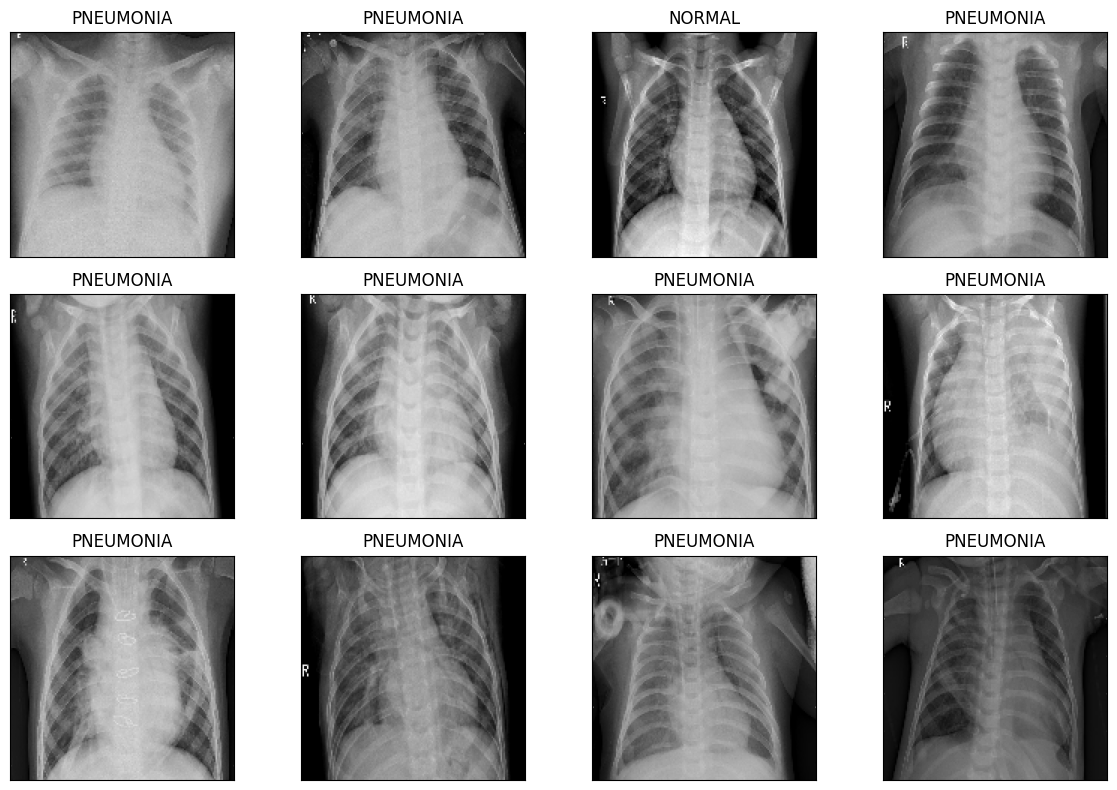

In [14]:
# Random sample 
sample_indices = np.random.choice(len(train_labels), 12, replace = False)

# Plot
fig, ax = plt.subplots(3, 4, figsize = (12, 8))
ax = ax.flatten()

for i, idx in enumerate(sample_indices):
    ax[i].imshow(train_images[idx], cmap = 'gray')
    ax[i].set_title(labels[int(train_labels[idx])])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

## 6. T-SNE with PCA
Before we begin constructing our models, we can dive further into our exploratory analysis by utilizing t-distributed Stochastic Neighbor Embedding (t-SNE) in tandem with Principal Component Analysis in order to visualize patterns in our data.

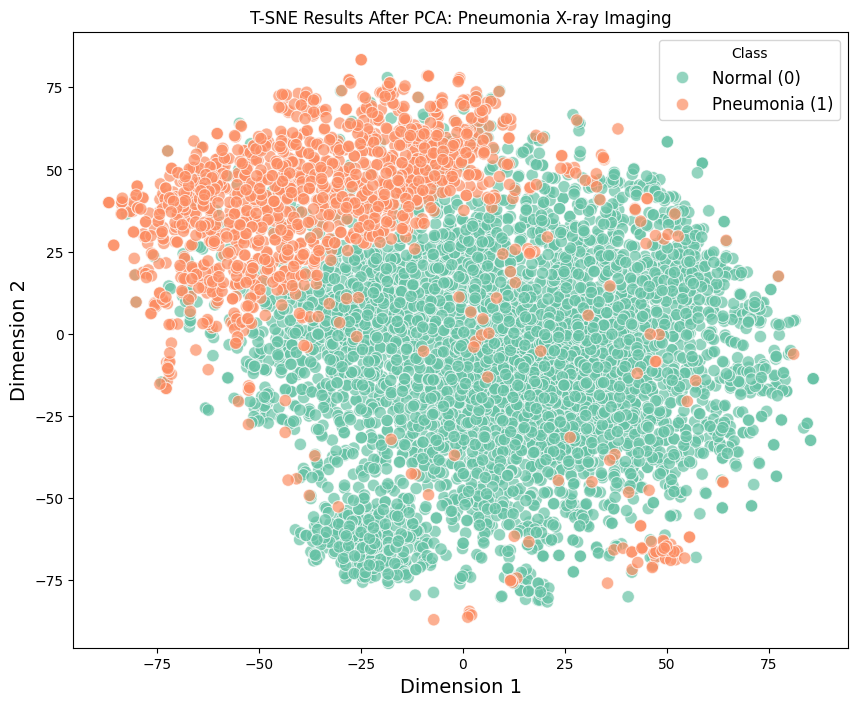

In [15]:
# Flatten the images
flat_images = train_images.reshape(train_images.shape[0], -1)

# PCA 
pca = PCA(n_components = 50)
pca_results = pca.fit_transform(flat_images)

# Standardize
scaler = StandardScaler()

# Fit 
pca_scaled = scaler.fit_transform(pca_results)

# Apply t-SNE to the PCA - reduced data
tsne = TSNE(n_components = 2,
            learning_rate = 'auto',
            n_iter = 4000,
            method = 'barnes_hut',
            random_state = 42)

# Fit 
tsne_results = tsne.fit_transform(pca_scaled)

# Define a dictionary to map class values to new labels
class_labels = {0: 'Normal (0)', 1: 'Pneumonia (1)'}

# Map the train_labels to the new labels
mapped_labels = [class_labels[label] for label in train_labels]

# Plot 
plt.figure(figsize = (10, 8))
sns.scatterplot(x = tsne_results[:, 0], y = tsne_results[:, 1], hue = mapped_labels, palette = 'Set2', alpha = 0.7, s = 80)

plt.title('T-SNE Results After PCA: Pneumonia X-ray Imaging')
plt.xlabel('Dimension 1', fontsize = 14)
plt.ylabel('Dimension 2', fontsize = 14)
plt.legend(title = "Class", fontsize = 12)

plt.show()

According to our visual, we can observe that our model correctly clusters similar data points together. However, there are some outliers and even some overlap.

## 7. Augmenting the Data

In [17]:
# Data Augmentation
augmented_data = ImageDataGenerator(
    rotation_range = 30,         
    width_shift_range = 0.1,     
    height_shift_range = 0.1,    
    zoom_range = 0.1,            
    horizontal_flip = True,      
    fill_mode = 'nearest'        
)

# Apply data augmentation only to training data
augmented_data = augmented_data.flow(train_images, train_labels, batch_size = 32)



##  8. Deep Neural Network
Our second model will be a simple DNN, to serve as a benchmark for accuracy. 

In [18]:
# DNN model
dnn_model = tf.keras.Sequential([
    Flatten(input_shape = train_images.shape[1:]),  
    Dense(units = 128, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')  
])

dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 22500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,880,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,888,449 (11.02 MB)

 Trainable params: 2,888,449 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile 
dnn_model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])

# Early stopping 
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

# Fit
dnn_model.fit(augmented_data, 
              epochs = 10, 
              validation_data = (val_images, val_labels), 
              callbacks = [early_stopping])

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7073 - loss: 0.8711 - val_accuracy: 0.6250 - val_loss: 0.6375
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8058 - loss: 0.4440 - val_accuracy: 0.5625 - val_loss: 0.7786
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8067 - loss: 0.4372 - val_accuracy: 0.6250 - val_loss: 0.6651
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8298 - loss: 0.3827 - val_accuracy: 0.6250 - val_loss: 0.7455
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8291 - loss: 0.3956 - val_accuracy: 0.6250 - val_loss: 0.7115
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8070 - loss: 0.4385 - val_accuracy: 0.6250 - val_loss: 0.6605


In [20]:
# Accuracy
test_loss, test_acc = dnn_model.evaluate(test_images, test_labels, verbose = 2)

print("\nTest accuracy:", test_acc)

20/20 - 0s - 3ms/step - accuracy: 0.8109 - loss: 0.4064

Test accuracy: 0.8108974099159241


In [21]:
# Classification Report
predictions = dnn_model.predict(test_images) > 0.5

print(classification_report(test_labels, predictions, target_names = labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

   PNEUMONIA       0.88      0.81      0.84       390
      NORMAL       0.72      0.81      0.76       234

    accuracy                           0.81       624
   macro avg       0.80      0.81      0.80       624
weighted avg       0.82      0.81      0.81       624



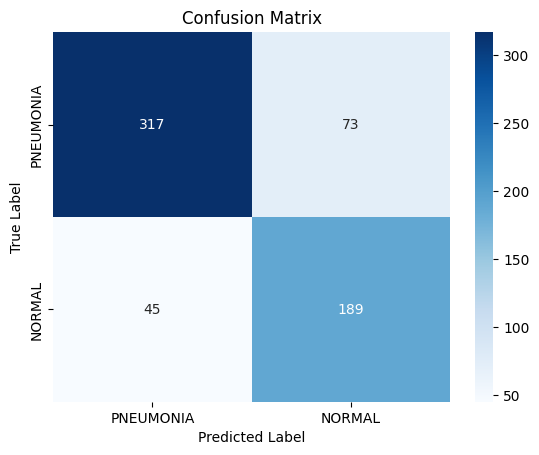

In [22]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = labels, yticklabels = labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

The performance of our model was neither particularly good nor bad. With an accuracy of approximately 81%, we can infer that our augmented data helped prevent overfitting. However, 118 images were still misclassified.

## 9. Convolutional Neural Network
For our final model, we will transition from a DNN to a CNN to improve classification performance. CNNs use convolutional layers to detect patterns and capture spatial hierarchies within the image, leading to increased accuracy and further reducing the risk of overfitting.

In [23]:
# CNN model
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation = 'relu', input_shape = (img_size, img_size, 1), padding = 'same'), 
    MaxPooling2D((2, 2)), 
    # Dropout(0.3),
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same'), 
    MaxPooling2D((2, 2)), 
    # Dropout(0.3),
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'), 
    MaxPooling2D((2, 2)),
    # Dropout(0.5),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,677,761 (10.21 MB)

 Trainable params: 2,677,761 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile the model
cnn_model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])

# Fit 
cnn_model.fit(augmented_data,
    epochs = 10,
    validation_data = (val_images, val_labels), 
    callbacks = [early_stopping]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.7394 - loss: 0.5467 - val_accuracy: 0.6250 - val_loss: 1.3702
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8898 - loss: 0.2632 - val_accuracy: 0.6250 - val_loss: 1.3547
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.8897 - loss: 0.2511 - val_accuracy: 0.7500 - val_loss: 0.7645
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9194 - loss: 0.1960 - val_accuracy: 0.7500 - val_loss: 0.8651
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9325 - loss: 0.1569 - val_accuracy: 0.8125 - val_loss: 0.4587
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9358 - loss: 0.1668 - val_accuracy: 0.6875 - val_loss: 0.6669
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9350 - loss: 0.1646 - val_accuracy: 0.8125 - val_loss: 0.4089
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9447 - loss: 0.1566 - 

In [25]:
# Accuracy
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels, verbose = 2)

print("\nTest accuracy:", test_acc)

20/20 - 0s - 15ms/step - accuracy: 0.9119 - loss: 0.3020

Test accuracy: 0.9118589758872986


In [26]:
# Classification Report
predictions = cnn_model.predict(test_images) > 0.5
print(classification_report(test_labels, predictions, target_names = labels))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

   PNEUMONIA       0.92      0.94      0.93       390
      NORMAL       0.89      0.87      0.88       234

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.91      0.91       624



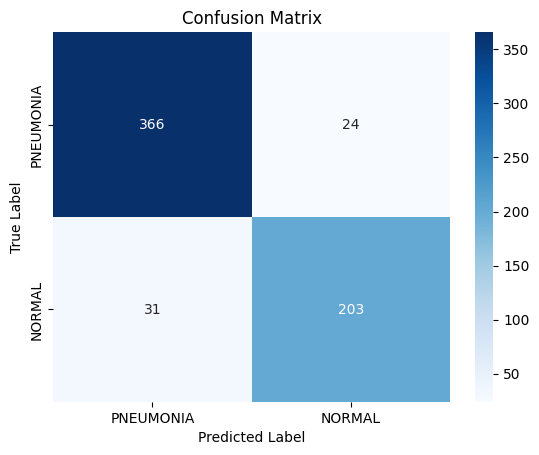

In [27]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = labels, yticklabels = labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Success! We achieved our desired classification accuracy of approximately 92%. Our expectation that the CNN would outperform the DNN was validated, and we also observed a reduction in misclassifications, with only 55 images incorrectly classified.

## 10. Conclusion
In conclusion, this project demonstrates the potential of machine learning to improve healthcare operations by automating diagnostic tasks. By utilizing deep learning models, we aimed to provide clinicians with data-driven insights, ultimately saving time and reducing costs in diagnosing illnesses. Specifically, we focused on classifying chest X-ray images of pediatric patients from Guangzhou Women and Children’s Medical Center to identify signs of pneumonia. After fine-tuning hyperparameters and optimizing performance, we reached a classification accuracy of approximately 92%. This outcome validated our expectation that a CNN would outperform a DNN, as the CNN’s ability to capture spatial hierarchies in the images improved classification accuracy and reduced the risk of overfitting. Additionally, fewer images were misclassified, with only 55 images incorrectly identified. Overall, this project demonstrates how machine learning frameworks like TensorFlow can provide faster, more accurate diagnoses, helping to make healthcare more accessible and affordable in underserved areas.